## <a id='toc1_2_'></a>[Authors](#toc0_)
* **Alireza Arbabi**
* **Hadi Babalou**
* **Ali Padyav**
* **Kasra Hajiheidari**

## <a id='toc1_3_'></a>[Table of Contents](#toc0_)

- [Authors](#toc1_2_)    
- [Table of Contents](#toc1_3_)  
- [Setting Up the Environment](#toc1_4_)    

## <a id='toc1_4_'></a>[Setting Up the Environment](#toc0_)

In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy import stats
import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


import warnings
warnings.filterwarnings("ignore")

In [172]:
carsData = pd.read_csv("cars.csv")
carsData.head(10)

,Sales in Thousands,Year Resale Value,Price in Thousands,Engine Size,Horsepower,Wheelbase,Width,Length,Curb Weight,Fuel Capacity,Fuel Efficiency,Power Perf Factor,Vehicle Type Car,Vehicle Type Passenger
0,16.919,16.360,21.500,1.8,140,101.2,67.3,172.4,2.639,13.2,28,58.280150,0,1
1,39.384,19.875,28.400,3.2,225,108.1,70.3,192.9,3.517,17.2,25,91.370778,0,1
2,20.397,22.255,23.990,1.8,150,102.6,68.2,178.0,2.998,16.4,27,62.777639,0,1
3,18.780,23.555,33.950,2.8,200,108.7,76.1,192.0,3.561,18.5,22,84.565105,0,1
4,91.561,12.475,21.975,3.1,175,109.0,72.7,194.6,3.368,17.5,25,71.181451,0,1
5,39.350,13.740,25.300,3.8,240,109.0,72.7,196.2,3.543,17.5,23,95.636703,0,1
6,27.851,20.190,31.965,3.8,205,113.8,74.7,206.8,3.778,18.5,24,85.828408,0,1
7,83.257,13.360,27.885,3.8,205,112.2,73.5,200.0,3.591,17.5,25,84.254526,0,1
8,6.536,25.725,39.665,4.6,275,108.0,75.5,200.6,3.843,19.0,22,113.765874,0,1
9,11.185,18.225,31.010,3.0,200,107.4,70.3,194.8,3.770,18.0,22,83.483094,0,1


## Correlation Matrix

In regression, the correlation matrix is used to determine the correlation between the independent variables. If the correlation between the independent variables is high, it is called multicollinearity. Multicollinearity can cause the model to be unstable and the coefficients to be unreliable. In this case, the model may not be able to make accurate predictions. Therefore, it is important to check the correlation between the independent variables before building the model.

In [173]:
def plot_correlation_matrix(correlation_matrix):
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
    plt.show()

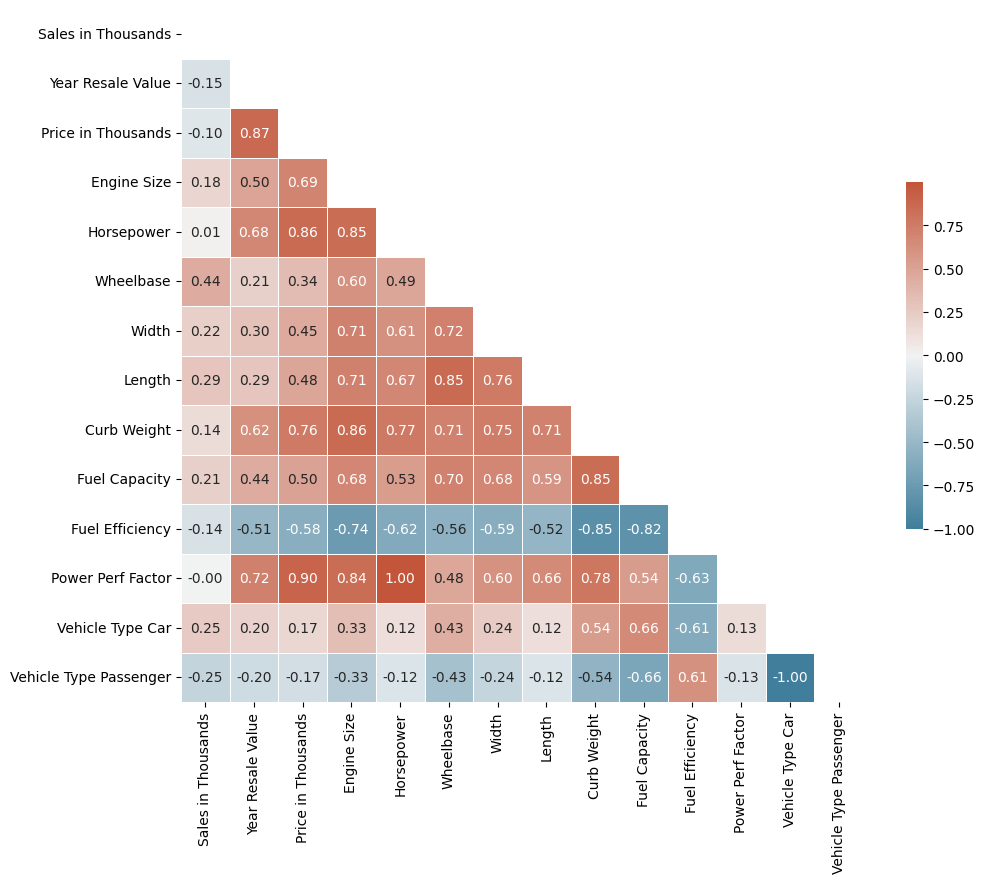

In [174]:
cars_data_corr = carsData.corr()
plot_correlation_matrix(cars_data_corr)

Drop the columns with high correlation to avoid multicollinearity.

In [175]:
cars_data_corr = cars_data_corr.abs()
upper = cars_data_corr.where(np.triu(np.ones(cars_data_corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
carsData = carsData.drop(to_drop, axis=1)

print("Columns dropped: ", to_drop)

Columns dropped:  ['Power Perf Factor', 'Vehicle Type Passenger']


## Multivariate Regression Implementation


First of all we split data into train and validation sets based on target column.

In [176]:
X = carsData.drop(['Horsepower','Price in Thousands'], axis=1)
Y = carsData[['Horsepower','Price in Thousands']]

Multiple regression is a statistical technique that aims to model the relationship between a dependent variable and two or more independent variables.

Multiple regression with n independent variables is expressed as follows:

$$f(x) = \beta _{0} + \beta_{1} x_{1} + \beta_{2} x_{2} + \beta_{3} x_{3} + \beta_{4} x_{4} + ... + \beta_{n} x_{n} + c $$

To optimize the model for accurate predictions, multiple regression commonly employs iterative algorithms such as gradient descent.

The main goal of the optimization process is to make our predictions as close as possible to the actual values.
We measure the prediction error using a cost function, usually denoted as $J(\beta)$.

$$ J(\beta)= \frac {1}{m} Σ_{i=0}^{m-1}(y_i - (\hat \beta _{0} + \hat \beta_{1} x_{1} + \hat \beta_{2} x_{2} + \hat \beta_{3} x_{3} + \hat \beta_{4} x_{4} + ... + \hat \beta_{n} x_{n}) )^2  $$

Gradient descent iteratively adjusts the coefficients $(\beta_i)$ to minimize the cost function. The update rule for each coefficient is:

$$\beta_{i} = \beta _ {i} - \alpha \frac {∂J(\beta)}{∂\beta_{i}}$$

$$ \frac {∂J(\beta)}{∂\beta_{i}} = \frac {2}{m}Σ_{j=0}^{m-1}(y_j - (\hat \beta _{0} + \hat \beta_{1} x_{j1} + \hat \beta_{2} x_{j2} + \hat \beta_{3} x_{j3} + \hat \beta_{4} x_{j4} + ... + \hat \beta_{n} x_{jn})) x_{ji} $$



`MultivariateLinearRegression` class is implemented to perform multiple regression on the dataset. The class has the following methods:

- `fit`: This method is used to train the model. It takes the training data as input and returns the coefficients of the model.

- `predict`: This method is used to make predictions. It takes the test data as input and returns the predicted values.

In [177]:
class MultivariateLinearRegression:
    def __init__(self, learning_rate=0.1, tolerance=1e-5, num_targets=1):
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.coefficients = []
        self.num_targets = num_targets

    def fit(self, X, y):
        X_std = (X - X.mean(axis=0)) / X.std(axis=0)
        X_b = np.c_[np.ones((X_std.shape[0], 1)), X_std]
        errors = []
        for i in range(self.num_targets):
            coefs = np.random.randn(X_b.shape[1])
            mse_error_per_iteration = []
            while(True):
                y_pred = np.dot(X_b, coefs)
                if(self.num_targets == 1):
                    error = y_pred - y
                    mse_err = mean_squared_error(y, y_pred)
                else:
                    error = y_pred - y.iloc[:, i]
                    mse_err = mean_squared_error(y.iloc[:, i], y_pred)
                mse_error_per_iteration.append(mse_err)
                
                gradient = np.dot(X_b.T, error) / len(y)
                new_coefficients = coefs - self.learning_rate * gradient*2
                change = np.linalg.norm(new_coefficients - coefs)

                coefs = new_coefficients
                
                if change < self.tolerance:
                    errors.append(mse_error_per_iteration)
                    self.coefficients.append(coefs)
                    break
        
        return errors
               
    def predict(self, X):
        X_std = (X - X.mean(axis=0)) / X.std(axis=0)
        X_b = np.c_[np.ones((X_std.shape[0], 1)), X_std]
        predictions = []
        for i in range (self.num_targets):
            predictions.append(np.dot(X_b, self.coefficients[i]))
        return predictions

In [178]:
x , x_t , y, y_t = train_test_split(X, Y, test_size=0.15, random_state=42)
y_hp = y['Horsepower']
y_hp_t = y_t['Horsepower']
y_price = y['Price in Thousands']
y_price_t = y_t['Price in Thousands']
model = MultivariateLinearRegression(num_targets=y.shape[1])
error = model.fit(x, y)
predictions = model.predict(x_t)
hp_error = error[0]
hp_predictions = predictions[0]
price_error = error[1]
price_predictions = predictions[1]

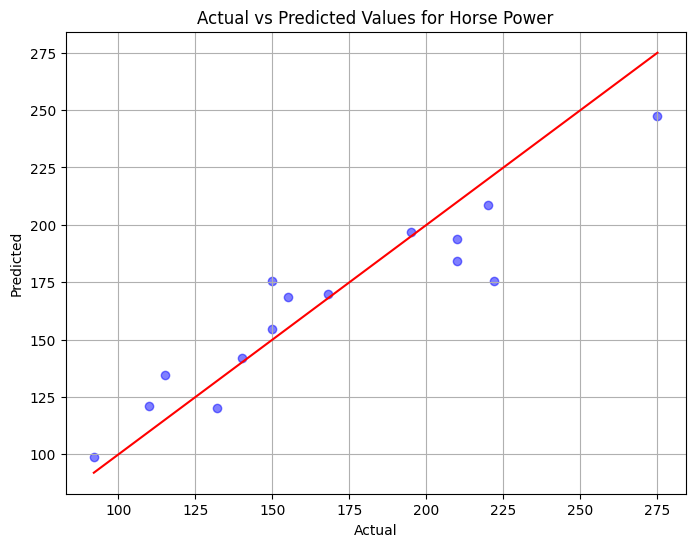

In [179]:
plt.figure(figsize=(8, 6))
plt.scatter(y_hp_t, hp_predictions, color='blue', alpha=0.5)
plt.plot([min(y_hp_t), max(y_hp_t)], [min(y_hp_t), max(y_hp_t)], color='red')  
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values for Horse Power')
plt.grid(True)
plt.show()

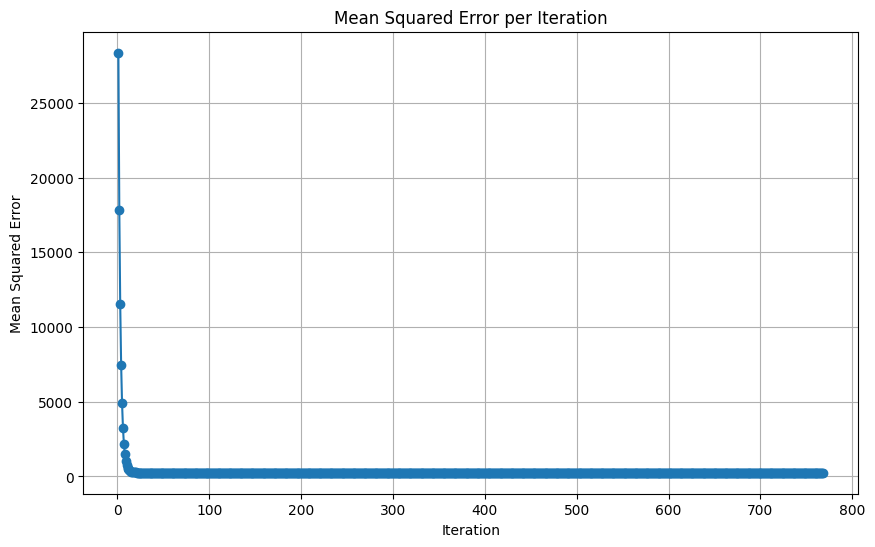

In [180]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(hp_error) + 1), hp_error, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error per Iteration')
plt.grid(True)
plt.show()

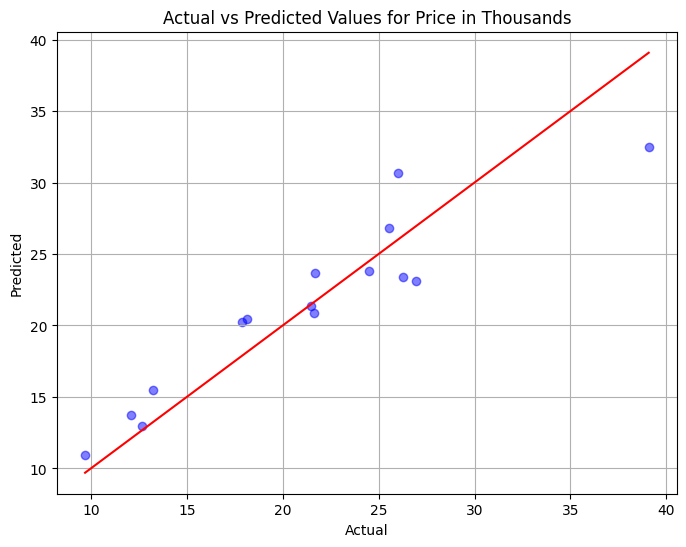

In [181]:
plt.figure(figsize=(8, 6))
plt.scatter(y_price_t, price_predictions, color='blue', alpha=0.5)
plt.plot([min(y_price_t), max(y_price_t)], [min(y_price_t), max(y_price_t)], color='red')  
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Values for Price in Thousands')
plt.grid(True)
plt.show()

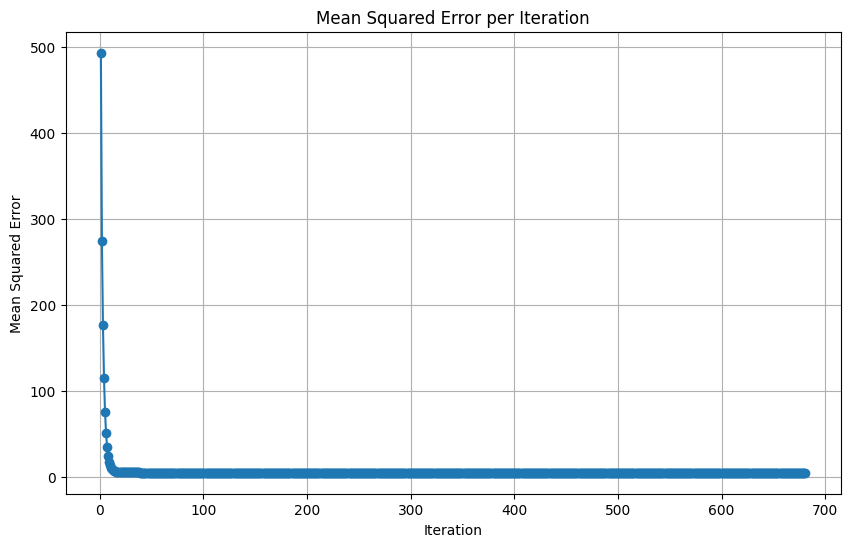

In [182]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(price_error) + 1),price_error, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error per Iteration')
plt.grid(True)
plt.show()

## K-Fold Cross-Validation

K-fold cross-validation is a technique used in machine learning to assess the performance of a model. Here's how it works:

Splitting the Data: The dataset is divided into K subsets of approximately equal size. These subsets are called folds.

Training and Validation: The model is trained K times, each time using K-1 folds for training and the remaining fold for validation.

Evaluation: For each training/validation iteration, the model is evaluated on the validation set, and the performance metrics are recorded.

Average Performance: After all K iterations are completed, the performance metrics are averaged to obtain a single performance estimate for the model.

This technique helps in obtaining a more reliable estimate of the model's performance compared to a single train-test split, especially when the dataset is limited in size.

In [183]:
def k_fold_cross_validation(X, Y, model, num_folds=5, random_state=None):
    np.random.seed(random_state)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    fold_size = len(X) // num_folds
    
    hp_errors = []
    price_errors = []

    for i in range(num_folds):
        start = i * fold_size
        end = (i + 1) * fold_size if i < num_folds - 1 else len(X)

        test_indices = indices[start:end]
        train_indices = np.concatenate((indices[:start], indices[end:]))

        X_train, Y_train = X.iloc[train_indices], Y.iloc[train_indices]
        X_test, Y_test = X.iloc[test_indices], Y.iloc[test_indices]

        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        
        hp_errors.append(mean_squared_error(Y_test['Horsepower'], predictions[0]))
        price_errors.append(mean_squared_error(Y_test['Price in Thousands'], predictions[1]))

    return hp_errors, price_errors


In [184]:
model = MultivariateLinearRegression(num_targets = Y.shape[1])
hp_errors, price_errors = k_fold_cross_validation(X, Y, model, num_folds=10, random_state=42)

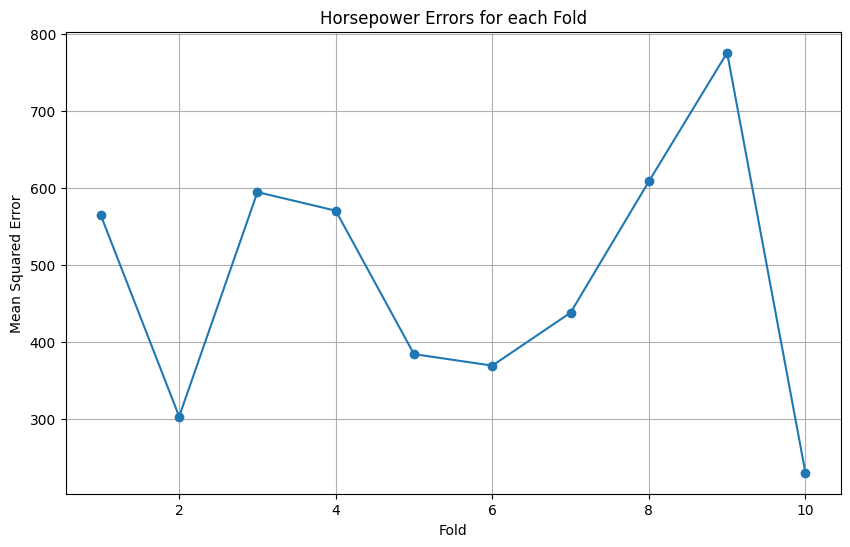

In [185]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(hp_errors) + 1), hp_errors, marker='o', linestyle='-')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.title('Horsepower Errors for each Fold')
plt.grid(True)
plt.show()

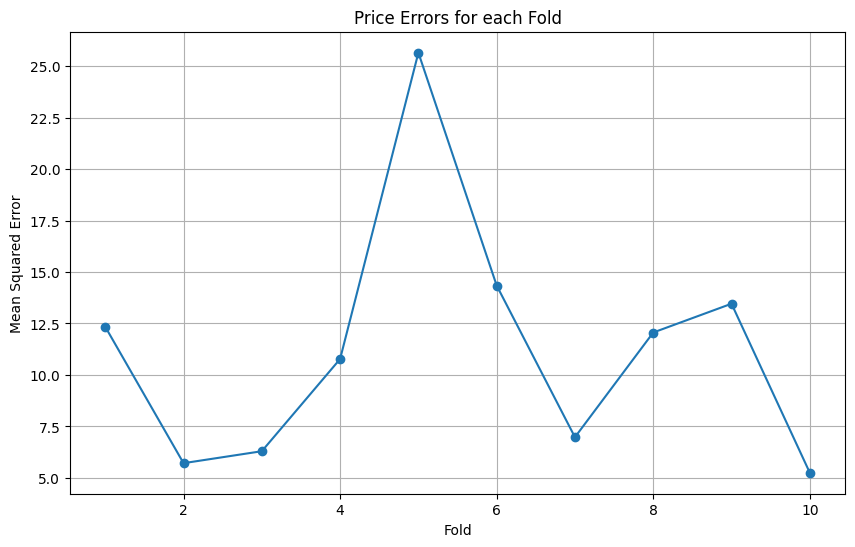

In [187]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(price_errors) + 1), price_errors, marker='o', linestyle='-')
plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.title('Price Errors for each Fold')
plt.grid(True)
plt.show()